In [1]:
import pandas as pd
from dbgsom.dbgsom_ import DBGSOM
import seaborn.objects as so
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.impute import SimpleImputer
from skimage.color import lab2rgb

In [2]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
)

In [3]:
data.replace(
    {
        -np.inf: 0,
        np.inf: 0,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [62]:
scaler = PowerTransformer()
# scaler = StandardScaler()
imputer = SimpleImputer(add_indicator=True)
ohe = OneHotEncoder(max_categories=10, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port", "Protocol"])],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
som = DBGSOM(
    max_epochs=500,
    random_state=32,
    spreading_factor=2,
    max_neurons=500,
    sigma_end=2,
    growth_criterion="entropy",
    min_samples_vertical_growth=200,
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("som", som),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [63]:
pipe.fit(X_train, y_train)


c:\tools\miniconda3\envs\py39_dbgsom\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 10%|█         | 51/500 [00:13<02:13,  3.37 epochs/s]

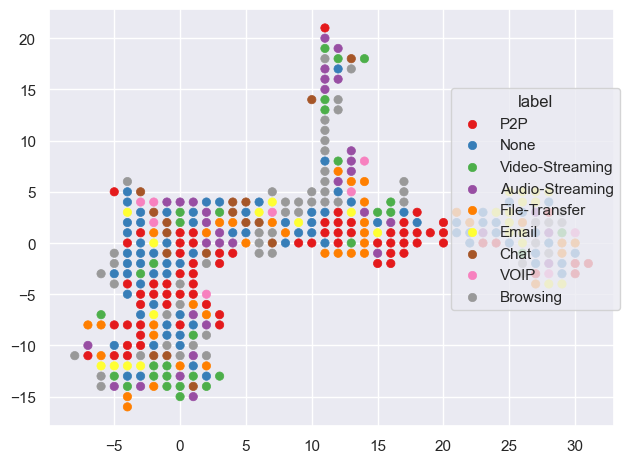

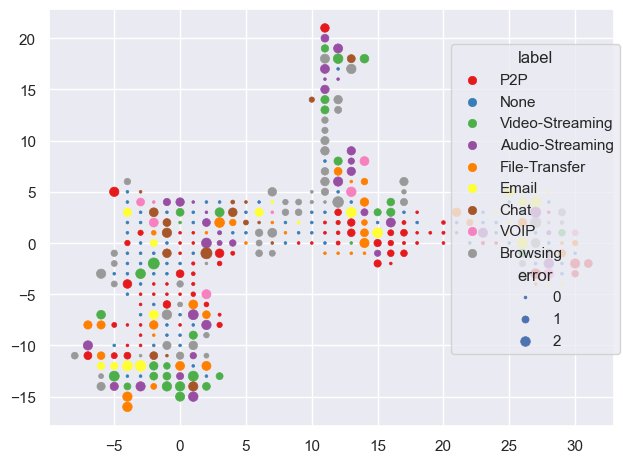

In [ ]:
som.plot(
    color="label",
    palette="Set1",
    # pointsize="density",
)
som.plot(
    color="label",
    palette="Set1",
    pointsize="error",
)


In [ ]:
weights = pd.DataFrame.from_dict(dict(som.som_.nodes)).T.set_index(
    np.arange(len(som.som_.nodes))
)["weight"]

weights_split = pd.DataFrame((pd.Series(feature) for feature in weights)).drop(120, axis=1)
weights_split.columns = col_transformer.get_feature_names_out()


In [ ]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(weights_split)

In [ ]:
colors_lab = pca_components
colors_lab[:, 0] = minmax_scale(colors_lab[:, 0], (0, 100))
colors_lab[:, 1] = minmax_scale(colors_lab[:, 1], (-128, 127))
colors_lab[:, 2] = minmax_scale(colors_lab[:, 2], (-128, 127))

colors_rgb = lab2rgb(colors_lab)


<Axes: >

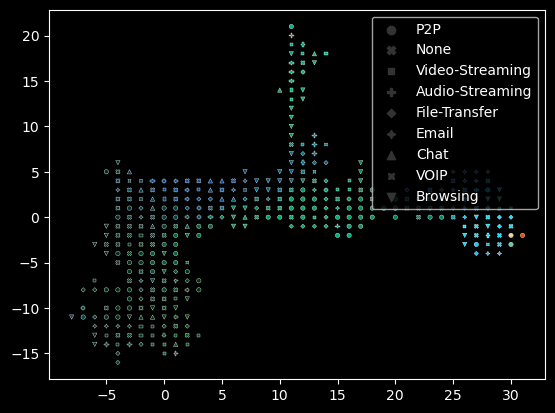

In [ ]:
sns.scatterplot(
    x=np.array(som.som_.nodes)[:, 0],
    y=np.array(som.som_.nodes)[:, 1],
    style=som.classes_[np.array(list(dict(som.som_.nodes.data("label")).values()))],
    # color=minmax_scale(pca_components),
    color=colors_rgb,
    # c=weights_split["Average Packet Size"],
    # legend="full",
    s=10,
)


<Axes: >

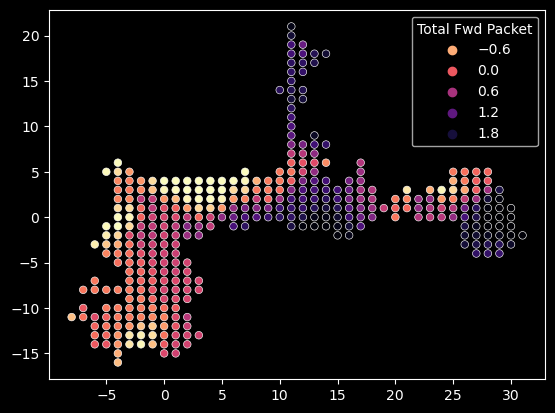

In [ ]:
sns.scatterplot(
    x=np.array(som.som_.nodes)[:, 0],
    y=np.array(som.som_.nodes)[:, 1],
    # color=colors_rgb,
    # hue=weights_split["Flow Bytes/s"],
    hue=weights_split["Total Fwd Packet"],
    palette="magma_r",
    s=30,
)

In [ ]:
som.topographic_error_


0.0842134021686906

In [ ]:
pipe.score(X_test, y_2_test)


0.8003278410536133

In [ ]:
f1_score(
    y_2_test,
    pipe.predict(X_test),
    # average="macro",
    average=None,
)


array([0.78138633, 0.85765006, 0.55233183, 0.57300131, 0.55225523,
       0.        , 0.97092504, 0.50394589, 0.52405363])

In [ ]:
# so.Plot(
#     np.array(som.som_.nodes)[:, 0], np.array(som.som_.nodes)[:, 1], color=colors_tuple
# ).add(so.Dots()).scale()


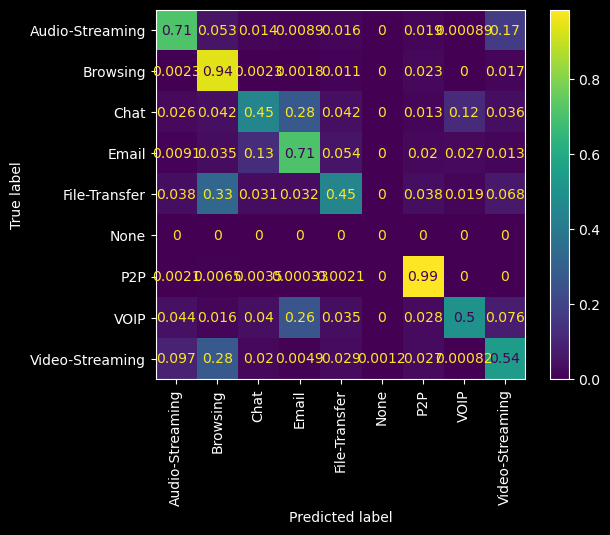

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_2_test,
    pipe.predict(X_test),
    normalize="true",
    xticks_rotation="vertical",
    # values_format="f{.3}"
)


In [ ]:
len(som.neurons_)

360